In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy
from tqdm import tqdm 
from scipy.interpolate import CubicSpline
%matplotlib notebook

# Parameters definition

In [2]:
t1 = 1.0
t2 = 1.0

def Ek(t, k):
    E = -2*t*(np.cos(k[0]) + np.cos([k[1]]))
    return E

def lamb_intra(Ek, U, Del):
    l = np.sqrt( np.square( Ek ) + np.square(U*Del) )
    return l

def lamb_inter(Ek, x, Del):
    l = np.sqrt( np.square( Ek ) + np.square(x*Del) )    # x = U - J
    return l
def lamb_CDW(Ek, x, Del):
    l = np.sqrt( np.square( Ek ) + np.square(x*Del/2)) # x = (3*U - 5*J)/2
    return l
def lamb_tot(Ek, x, y, z, Del_m, Del_mm, Del_cdw ):
    l = np.sqrt( np.square( Ek ) + np.square(x*Del_m)  + np.square(y*Del_mm)  + np.square(z*Del_cdw/2) )
    # x = U
    # y = U - 2J
    # z = (3*U - 5*J)/2
    return l

In [16]:
""" How many k points in the BZ """

grid_kx = np.linspace(-np.pi, np.pi, 300, endpoint = False)
grid_ky = np.linspace(-np.pi, np.pi, 300, endpoint = False)
grid_Ek = np.zeros((len(grid_kx), len(grid_ky)))

n = 0
for (i, kx) in enumerate(grid_kx): 
    for (j, ky) in enumerate(grid_ky):
        k = np.array([kx, ky])
        grid_Ek[i][j] = Ek(t1, k)
        if (grid_Ek[i][j] < 0):
            n += 1
            
print("Density per site", n/np.square(len(grid_kx)))

Density per site 0.5012


In [6]:
U_array = np.r_[ -30 : 2 : 1000j ]

Del_intra_array = np.zeros(len(U_array))
Energy_intra_array = np.zeros(len(U_array))
guess = 0.5

for l in tqdm(range(len(U_array))):
    U = U_array[l]
    for m in range(100):
        Del = 0.0
        Del = np.sum( 1.0/lamb_intra(grid_Ek, U, guess) )
        Del = -0.5*Del*U/np.square(len(grid_kx))*guess
        if(abs(Del - guess) < 1.0E-4):
            energy_Del = 0.0
            energy_Del0 = 0.0
            
            energy_Del = - np.sum( lamb_intra(grid_Ek, U, Del)  - grid_Ek )
            energy_Del0 = - np.sum( lamb_intra(grid_Ek, U, 0)  - grid_Ek )
                    
            energy_Del = 2*( energy_Del/np.square(len(grid_kx)) - U*Del**2.0 )
            energy_Del0 = 2*( energy_Del0/np.square(len(grid_kx)) )
            if(energy_Del < energy_Del0):
                Del_intra_array[l] = Del
                Energy_intra_array[l] = energy_Del
            else:
                Del_intra_array[l] = 0.0
                Energy_intra_array[l] = energy_Del0
            break
            
        elif(m == 99):
            Del_intra_array[l] = 0.0
            
            energy_Del0 = - np.sum( lamb_intra(grid_Ek, U, 0)  - grid_Ek )
            energy_Del0 = 2*( energy_Del0/np.square(len(grid_kx)) )
            Energy_intra_array[l] = energy_Del0
            
        guess = guess*0.5 + Del*0.5

100%|███████████████████████████████████████| 1000/1000 [00:30<00:00, 32.53it/s]


In [5]:
U = -1

energy = lambda Del : 2*( - np.sum( lamb_intra(grid_Ek, U, Del)  - grid_Ek )/np.square(len(grid_kx)) - U*Del**2.0 )
a = scipy.optimize.minimize( energy , 0.1, method = 'SLSQP')
print(a.x)
#type(a.x)

[0.06144096]


In [ ]:
U_array = np.r_[ -10 :2  : 100j ]

Del_intra_array = np.zeros(len(U_array))
cons=({'type': 'ineq', 'fun': lambda Del: 0.5 - Del},{'type': 'ineq', 'fun': lambda Del: Del})

for l in tqdm(range(len(U_array))):
    U = U_array[l]
    
    energy = lambda Del : 2*( - np.sum( lamb_intra(grid_Ek, U, Del)  - grid_Ek )/np.square(len(grid_kx)) - U*Del**2.0 )
    a = scipy.optimize.minimize( energy , np.random.random(), method = 'SLSQP', constraints= cons )
    
    
    Del_intra_array[l] = a.x

In [11]:
with open('results/intra_orbital_SC.dat', 'w') as data:
    data.write("# U  Del  E")
    for l in range(len(U_array)):
        U = U_array[l]
        data.write("\n{0:5.4f}  {1:5.4f}  {2:5.4f}".format(U, Del_intra_array[l], Energy_intra_array[l]))

In [9]:
fname = "results/intra_orbital_SC.dat"
data = np.loadtxt(fname)
U_array = data[:,0]
Del_intra_array = data[:,1]
spl = CubicSpline(U_array, Del_intra_array )

In [38]:
""" Optimization with minimization of the energy"""
U_array = np.r_[ -20 :2  : 100j ]
mu = -2.0
Del_intra_array = np.zeros(len(U_array))
cons=({'type': 'ineq', 'fun': lambda Del: 0.5 - Del},{'type': 'ineq', 'fun': lambda Del: Del})

for l in tqdm(range(len(U_array))):
    U = U_array[l]
    
    if(U > 0.0):
        Del_intra_array[l] = 0.0 
    else:    
        energy = lambda Del : 2*( - np.sum( lamb_intra(grid_Ek - mu, U, Del)  - grid_Ek )/np.square(len(grid_kx)) - U*Del**2.0 )
        a = scipy.optimize.minimize( energy , np.random.random(), method = 'SLSQP', constraints= cons )
    
        Del_intra_array[l] = a.x

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 248.25it/s]


<IPython.core.display.Javascript object>


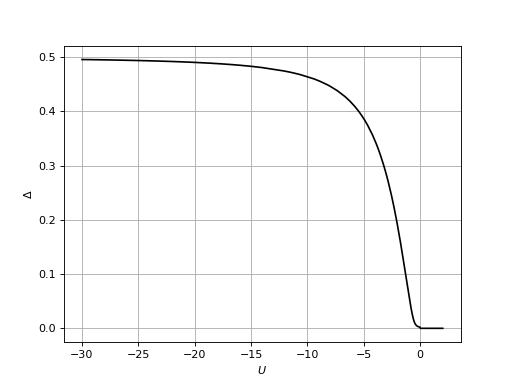

In [10]:
"""Plot of the order parameter"""
plt.figure()

plt.title(r'')
plt.grid()
#plt.xlim([-20,3])
plt.xlabel(r'$U$')
plt.ylabel(r'$\Delta$')
plt.plot(U_array, Del_intra_array, '-', color = 'black')
#plt.show()
plt.savefig('results/intra_orbital_SC_section.png')

In [14]:
U_array = np.r_[ -10 : -0.000001 : 100j ]
J_array = np.r_[ -10 : 10 : 200j ]
Del_intra_array = np.zeros([len(U_array),len(J_array)])

for l in tqdm(range(len(U_array))):
    U = U_array[l]
    for s in range(len(J_array)):
        J = J_array[s]
        Del_intra_array[l][s] = spl(U)
        

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 292.91it/s]


<IPython.core.display.Javascript object>


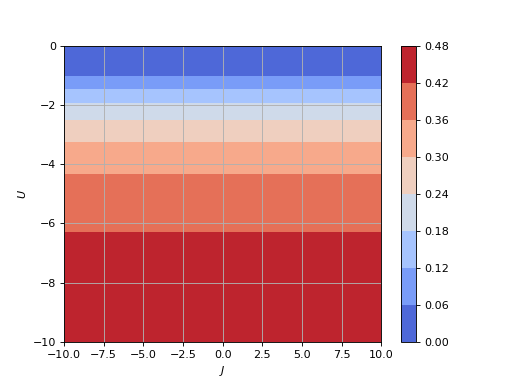

In [15]:
"""Plot of the order parameter"""
cmaps = ['viridis', 'coolwarm']

plt.figure()

vmin_Del, vmax_Del = np.min(Del_intra_array), np.max(Del_intra_array)
#plt.pcolormesh(J_array, U_array, Del_array , cmap=cmaps[1], vmin=vmin_Del, vmax=vmax_Del)
plt.contourf(J_array, U_array, Del_intra_array, cmap=cmaps[1], vmin=vmin_Del, vmax=vmax_Del)
plt.colorbar()
plt.title(r'')
plt.grid()
plt.xlim([-10,10])
plt.ylim([-10,0])
plt.xlabel(r'$J$')
plt.ylabel(r'$U$')
#plt.show()
plt.savefig('results/intra_orbital_SC_grid.png')

# Inter-orbital SC

In [183]:
x_array = np.r_[ -30 : 20: 1000j ]

Del_inter_sec_array = np.zeros(len(x_array))
Energy_inter_array = np.zeros(len(x_array))
guess = 0.5

for l in tqdm(range(len(x_array))):
    x = x_array[l]    # x = U -2*J
    for m in range(100):
        Del = 0.0
        Del = np.sum( 1.0/lamb_inter(grid_Ek, x, guess) )
        Del = -0.5*Del*x/np.square(len(grid_kx))*guess
        if(abs(Del - guess) < 1.0E-4):
            energy_Del = 0.0
            energy_Del0 = 0.0
            
            energy_Del = - np.sum( lamb_inter(grid_Ek, x, Del) - grid_Ek )
            energy_Del0 = - np.sum( lamb_inter(grid_Ek, x, 0) - grid_Ek )
                    
            energy_Del = 2*( energy_Del/np.square(len(grid_kx)) - x*Del**2.0 )
            energy_Del0 = 2*( energy_Del0/np.square(len(grid_kx)) )
            if(energy_Del < energy_Del0):
                Del_inter_sec_array[l] = Del
                Energy_inter_array[l] = energy_Del
            else:
                Del_inter_sec_array[l] = 0.0
                Energy_inter_array[l] = energy_Del0
            break
        elif(m == 99):
            Del_inter_array[l] = 0.0
            
            energy_Del0 = - np.sum( lamb_inter(grid_Ek, x, 0)  - grid_Ek )
            energy_Del0 = 2*( energy_Del0/np.square(len(grid_kx)) )
            Energy_inter_array[l] = energy_Del0
        guess = guess*0.5 + Del*0.5

100%|███████████████████████████████████████| 1000/1000 [00:40<00:00, 24.41it/s]


In [184]:
with open('results/inter_orbital_SC.dat', 'w') as data:
    data.write("\n#(U-2J)  Del")
    for l in range(len(x_array)):
        x = x_array[l]
        data.write("\n{0:5.4f}  {1:5.4f}  {2:5.4f}".format(x, Del_inter_sec_array[l], Energy_inter_array[l]))

In [16]:
fname = "results/inter_orbital_SC.dat"
data = np.loadtxt(fname)
x_array = data[:,0]
Del_inter_sec_array = data[:,1]
spl2 = CubicSpline(x_array, Del_inter_sec_array )

<IPython.core.display.Javascript object>


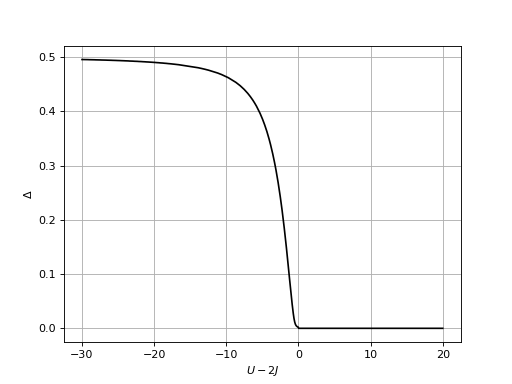

In [17]:
"""Plot of the order parameter"""
plt.figure()

plt.title(r'')
plt.grid()
#plt.xlim([-20,3])
plt.xlabel(r'$U - 2J$')
plt.ylabel(r'$\Delta$')
plt.plot(x_array, Del_inter_sec_array, '-', color = 'black')
#plt.show()
plt.savefig('results/inter_orbital_SC_section.png')

In [21]:
U_array = np.r_[ -10 : -0.000001 : 100j ]
J_array = np.r_[ -10 : 10 : 200j ]
Del_inter_array = np.zeros([len(U_array),len(J_array)])

for l in tqdm(range(len(U_array))):
    U = U_array[l]
    for s in range(len(J_array)):
        J = J_array[s]
        x = U - 2*J
        Del_inter_array[l][s] = spl2(x)
        if (spl2(x)<10**(-3)):
            Del_inter_array[l][s] = 0.0

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 140.49it/s]


<IPython.core.display.Javascript object>


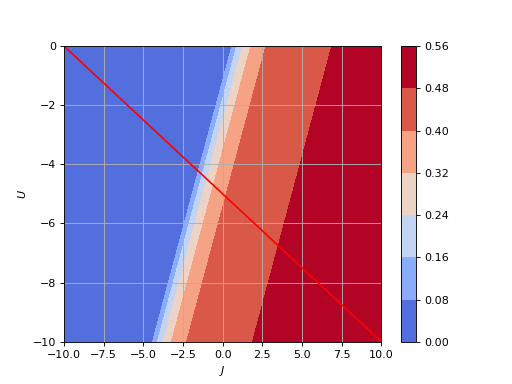

In [23]:
"""Plot of the order parameter"""
cmaps = ['viridis', 'coolwarm']

plt.figure()

vmin_Del, vmax_Del = np.min(Del_inter_array), np.max(Del_inter_array)
#plt.pcolormesh(J_array, U_array, Del_array , cmap=cmaps[1], vmin=vmin_Del, vmax=vmax_Del)
plt.contourf(J_array, U_array, Del_inter_array, cmap=cmaps[1], vmin=vmin_Del, vmax=vmax_Del)
plt.colorbar()
plt.title(r'')
plt.grid()
plt.xlim([-10,10])
plt.ylim([-10,0])
plt.xlabel(r'$J$')
plt.ylabel(r'$U$')
z = -1/2*J_array - 5
plt.plot(J_array, z, '-', color = 'red')
#plt.show()
plt.savefig('results/inter_orbital_SC_grid.png')

# Charge density wave

In [176]:
def Rotate(theta,vec):
    matrix = np.array([[np.cos(theta),-np.sin(theta)],[np.cos(theta),np.sin(theta)]])
    rotated = matrix.dot(vec)
    return rotated

In [177]:
gridR_kx = np.linspace(-np.pi/np.sqrt(2), np.pi/np.sqrt(2), 700, endpoint = False)
gridR_ky = np.linspace(-np.pi/np.sqrt(2), np.pi/np.sqrt(2), 700, endpoint = False)
gridR_Ek = np.zeros((len(gridR_kx), len(gridR_ky)))


k_test=np.zeros([len(gridR_kx)*len(gridR_ky),2])
## WE INIZIALIZE THE REDUCED BRILLOUIN ZONE ###

for (i, kx) in enumerate(gridR_kx): 
    for (j, ky) in enumerate(gridR_ky):
        k = np.array([kx, ky])
        k = Rotate(np.pi/4,k)
        k_test[i+j*len(gridR_kx)] = k
        gridR_Ek[i][j] = Ek(t1, k)

In [5]:
x_array = np.r_[ -40 : 25: 1000j ]

Del_CDW_sec_array = np.zeros(len(x_array))
Energy_CDW_array = np.zeros(len(x_array))
guess = 0.5

for l in tqdm(range(len(x_array))):
    x = x_array[l]    # x = (3U - 5J)/2
    for m in range(100):
        Del = 0.0
        Del = np.sum( 1.0/lamb_CDW(grid_Ek, x, guess) )
        Del = -x*Del/np.square(len(grid_kx))*guess
        if(abs(Del - guess) < 1.0E-4):
            energy_Del = 0.0
            energy_Del0 = 0.0
            
            energy_Del = -2*np.sum( lamb_CDW(grid_Ek, x, Del) )
            energy_Del0 = -2*np.sum( lamb_CDW(grid_Ek, x, 0) ) 
                        
            energy_Del =  energy_Del/np.square(len(grid_kx)) - x*Del**2 /4 
            energy_Del0 =  energy_Del0/np.square(len(grid_kx)) 
            
            if(energy_Del < energy_Del0):
                Del_CDW_sec_array[l] = Del
                Energy_CDW_array[l] = energy_Del
            else:
                Del_CDW_sec_array[l] = 0.0
                Energy_CDW_array[l] = energy_Del0
            break

        elif(m == 99):
            Del_CDW_sec_array[l] = 0.0
            
            energy_Del0 = - 2*np.sum( lamb_CDW(grid_Ek, x, 0) )
            energy_Del0 = energy_Del0/np.square(len(grid_kx))
            Energy_CDW_array[l] = energy_Del0
        guess = guess*0.5 + Del*0.5

100%|███████████████████████████████████████| 1000/1000 [02:11<00:00,  7.62it/s]


In [7]:
with open('results/CDW.dat', 'w') as data:
    data.write("\n#(3U-5J)/2  Del")
    for l in range(len(x_array)):
        x = x_array[l]
        data.write("\n{0:5.4f}  {1:5.4f}  {2:5.4f}".format(x, Del_CDW_sec_array[l], Energy_CDW_array[l]))

In [8]:
fname = "results/CDW.dat"
data = np.loadtxt(fname)
x_array = data[:,0]
Del_CDW_sec_array = data[:,1]
spl3 = CubicSpline(x_array, Del_CDW_sec_array )

<IPython.core.display.Javascript object>


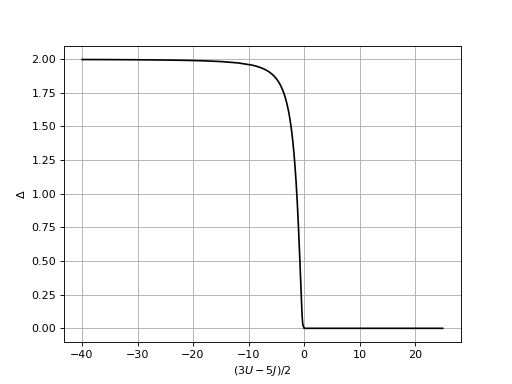

In [9]:
"""Plot of the order parameter"""
plt.figure()

plt.title(r'')
plt.grid()
#plt.xlim([-20,3])
plt.xlabel(r'$(3U-5J)/2$')
plt.ylabel(r'$\Delta$')
plt.plot(x_array, Del_CDW_sec_array, '-', color = 'black')
plt.show()
#plt.savefig('CDW_section.png')

In [10]:
U_array = np.r_[ -10 : -0.000001 : 100j ]
J_array = np.r_[ -10 : 10 : 200j ]
Del_CDW_array = np.zeros([len(U_array),len(J_array)])

for l in tqdm(range(len(U_array))):
    U = U_array[l]
    for s in range(len(J_array)):
        J = J_array[s]
        x = (3*U - 5*J)/2.0
        
        if (x > 0.0):
            Del_CDW_array[l][s] = 0.0
        
        elif (x < -20.0):
            Del_CDW_array[l][s] = 2.0
        
        elif (spl3(x) < 10**(-3)):
            Del_CDW_array[l][s] = 0.0

        else:
            Del_CDW_array[l][s] = spl3(x)
        

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 264.49it/s]


<IPython.core.display.Javascript object>


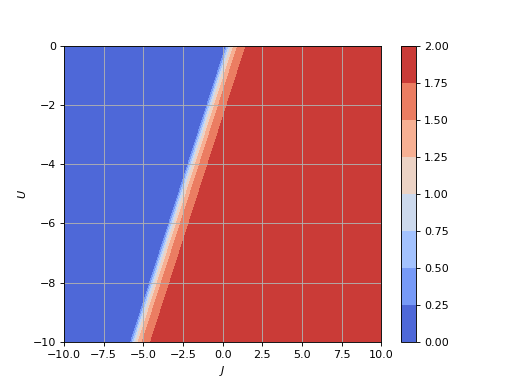

In [11]:
"""Plot of the order parameter"""
cmaps = ['viridis', 'coolwarm']

plt.figure()

vmin_Del, vmax_Del = np.min(Del_CDW_array), np.max(Del_CDW_array)
plt.contourf(J_array, U_array, Del_CDW_array, cmap=cmaps[1], vmin=vmin_Del, vmax=vmax_Del)
plt.colorbar()
plt.title(r'')
plt.grid()
plt.xlim([-10,10])
plt.ylim([-10,0])
plt.xlabel(r'$J$')
plt.ylabel(r'$U$')
#plt.plot(J_array, y, '-', color = 'black')
#plt.plot(J_array, z, '-', color = 'red')
plt.show()
#plt.savefig('results/CDW.png')

# Compare the phases

In [2]:
fname = "results/intra_orbital_SC.dat"
data = np.loadtxt(fname)
x_intra_array = data[:,0]
Del_intra_array = data[:,1]
Energy_intra_array = data[:,2]
Del_intra = CubicSpline(x_intra_array, Del_intra_array )
En_intra = CubicSpline(x_intra_array, Energy_intra_array )

fname = "results/inter_orbital_SC.dat"
data = np.loadtxt(fname)
x_inter_array = data[:,0]
Del_inter_array = data[:,1]
Energy_inter_array = data[:,2]
Del_inter = CubicSpline(x_inter_array, Del_inter_array )
En_inter = CubicSpline(x_inter_array, Energy_inter_array )

fname = "results/CDW.dat"
data = np.loadtxt(fname)
x_CDW_array = data[:,0]
Del_CDW_array = data[:,1]
Energy_CDW_array = data[:,2]
Del_CDW = CubicSpline(x_CDW_array, Del_CDW_array )
En_CDW = CubicSpline(x_CDW_array, Energy_CDW_array )

<IPython.core.display.Javascript object>


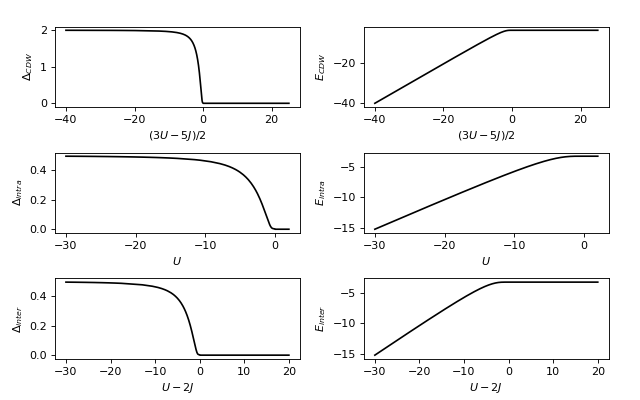

Text(391.9040404040403, 0.5, '$E_{inter}$')

In [3]:
"""Plot of the order parameter and the energy"""

cmaps = ['viridis', 'coolwarm']
fig, axs = plt.subplots(3,2, figsize=(8,5))
fig.tight_layout(pad=2.0)
ax = axs[0,0]
#ax.set_title()
ax.plot(x_CDW_array, Del_CDW_array, '-', color = 'black',label="CDW")
ax.set_xlabel(r"$(3U-5J)/2$")
ax.set_ylabel(r"$\Delta_{CDW}$")
#ax.legend()
ax = axs[0,1]
ax.plot(x_CDW_array, Energy_CDW_array, '-', color = 'black')
ax.set_xlabel(r"$(3U-5J)/2$")
ax.set_ylabel(r"$E_{CDW}$")
ax = axs[1,0]
ax.plot(x_intra_array, Del_intra_array, '-', color = 'black')
ax.set_xlabel(r"$U$")
ax.set_ylabel(r"$\Delta_{intra}$")
#ax.set(xlabel="3U-5J")
ax = axs[1,1]
ax.plot(x_intra_array, Energy_intra_array, '-', color = 'black')
ax.set_xlabel(r"$U$")
ax.set_ylabel(r"$E_{intra}$")
ax = axs[2,0]
ax.plot(x_inter_array, Del_inter_array, '-', color = 'black')
ax.set_xlabel(r"$U-2J$")
ax.set_ylabel(r"$\Delta_{inter}$")
#ax.set(xlabel="3U-5J")
ax = axs[2,1]
ax.plot(x_inter_array, Energy_inter_array, '-', color = 'black')
ax.set_xlabel(r"$U-2J$")
ax.set_ylabel(r"$E_{inter}$")

In [4]:
U_array = np.r_[ -10 : -0.000001 : 100j ]
J_array = np.r_[ -10 : 10 : 200j ]
PDiag=np.zeros((len(U_array),len(J_array),2))
#DelPD=np.zeros((len(U_array),len(J_array)))

for l in tqdm(range(len(U_array))):
    U = U_array[l]
    for s in range(len(J_array)):
        J = J_array[s]
        E1 = En_intra( U )
        E2 = En_inter( U - 2*J )
        E3 = En_CDW( (3*U - 5*J)/2.0 )
        vec_E = np.r_[E1, E2, E3]
        
        Del1 = Del_intra( U )
        Del2 = Del_inter( U - 2*J )
        Del3 = Del_CDW( (3*U - 5*J)/2.0 )
        vec_Del = np.r_[Del1, Del2, Del3]
        minEphs=np.argmin(vec_E)
        #print(minEphs)
        #print('\n')
       
        #PDiag[l,s]= Del1
        
        PDiag[l,s][0]= minEphs
        PDiag[l,s][1]= vec_Del[minEphs]
        

100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 22.31it/s]


In [5]:
from numpy.ma import masked_array
Deltaintra=masked_array(PDiag[:,:,1],PDiag[:,:,0]>0)
Deltainter=masked_array(PDiag[:,:,1],abs(PDiag[:,:,0]-1)>0)
DeltaCDW=masked_array(PDiag[:,:,1],PDiag[:,:,0]<2)

<IPython.core.display.Javascript object>


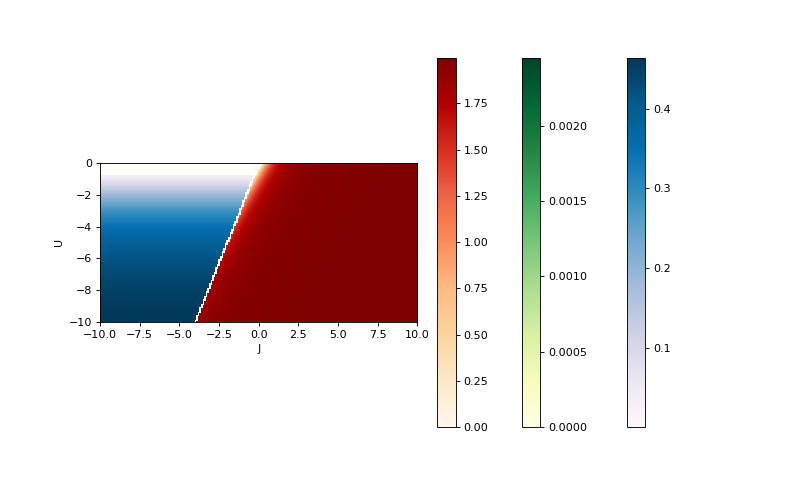

Text(0, 0.5, 'U')

In [8]:
cmaps=['PuBu','YlGn','OrRd']
plt.figure(figsize =(10,6))
plt.imshow(Deltaintra[::-1,:],cmap=cmaps[0],extent=[-10,10,-10,0])
plt.colorbar()
plt.imshow(Deltainter[::-1,:],cmap=cmaps[1],extent=[-10,10,-10,0])
plt.colorbar()
plt.imshow(DeltaCDW[::-1,:],cmap=cmaps[2],extent=[-10,10,-10,0])
plt.colorbar()
plt.xlabel('J')
plt.ylabel('U')

# Competing orders

In [33]:
""" Optimization with the minimization of the energy """

U_array = np.r_[ -10 : -0.001 : 100j ]
J_array = np.r_[ -10.1 : 2 : 200j ]

Del_intra_array = np.zeros((len(U_array),len(J_array)))
Del_inter_array = np.zeros((len(U_array),len(J_array)))
Del_CDW_array = np.zeros((len(U_array),len(J_array)))

""" Constraints """
cons1=({'type': 'eq', 'fun': lambda Del: Del[0]}, {'type': 'eq', 'fun': lambda Del: Del[1]}, {'type': 'eq', 'fun': lambda Del: Del[2]})
cons2=({'type': 'eq', 'fun': lambda Del: Del[0]}, {'type': 'eq', 'fun': lambda Del: Del[1]},{'type': 'ineq', 'fun': lambda Del: Del[2]})
cons3=({'type': 'eq', 'fun': lambda Del: Del[0]}, {'type': 'eq', 'fun': lambda Del: Del[2]},{'type': 'ineq', 'fun': lambda Del: Del[1]})
cons4=({'type': 'eq', 'fun': lambda Del: Del[0]},{'type': 'ineq', 'fun': lambda Del: Del[1]},{'type': 'ineq', 'fun': lambda Del: Del[2]})
cons5=({'type': 'eq', 'fun': lambda Del: Del[1]}, {'type': 'eq', 'fun': lambda Del: Del[2]},{'type': 'ineq', 'fun': lambda Del: Del[0]})
cons6=({'type': 'eq', 'fun': lambda Del: Del[1]},{'type': 'ineq', 'fun': lambda Del: Del[0]},{'type': 'ineq', 'fun': lambda Del: Del[2]})
cons7=({'type': 'eq', 'fun': lambda Del: Del[2]},{'type': 'ineq', 'fun': lambda Del: Del[0]},{'type': 'ineq', 'fun': lambda Del: Del[1]})
cons8=({'type': 'ineq', 'fun': lambda Del: Del[0]}, {'type': 'ineq', 'fun': lambda Del: Del[1]}, {'type': 'ineq', 'fun': lambda Del: Del[2]})
for l in tqdm(range(len(U_array))):
    U = U_array[l]
    for s in range(len(J_array)):
        J = J_array[s]
        x = U
        y = U - 2*J
        z = (3*U-5*J)/2
        energy = lambda Del : -2.0*np.sum( lamb_tot(grid_Ek, x, y, z, Del[0], Del[1], Del[2]))/np.square(len(grid_kx)) -2*x*Del[0]**2.0 - 2*y*Del[1]**2.0 -z*(Del[2]/2)**2.0 
        
        if( x > 0):
            if ( y > 0):
                if ( z > 0 ):
                    a = scipy.optimize.minimize( energy , np.random.random(3), method = 'SLSQP', constraints= cons1 )
                else:
                    a = scipy.optimize.minimize( energy , np.random.random(3), method = 'SLSQP', constraints= cons2 )
                    
            else:
                
                if ( z > 0 ):
                    a = scipy.optimize.minimize( energy , np.random.random(3), method = 'SLSQP', constraints= cons3 )
                else:
                    a = scipy.optimize.minimize( energy , np.random.random(3), method = 'SLSQP', constraints= cons4 )
        
        else:
            if ( y > 0):
                if ( z > 0 ):
                    a  = scipy.optimize.minimize( energy , np.random.random(3), method = 'SLSQP', constraints= cons5 )
                else:
                    a = scipy.optimize.minimize( energy , np.random.random(3), method = 'SLSQP', constraints= cons6 )
            else:
                if ( z > 0 ):
                    a = scipy.optimize.minimize( energy , np.random.random(3), method = 'SLSQP', constraints= cons7 )
                else:   
                    a = scipy.optimize.minimize( energy , np.random.random(3), method = 'SLSQP',constraints= cons8)
                    
        Del_intra_array[l][s] = a.x[0]
        Del_inter_array[l][s] = a.x[1]
        Del_CDW_array[l][s] = a.x[2]

100%|█████████████████████████████████████████| 100/100 [05:30<00:00,  3.30s/it]


In [34]:
with open('results/competing_intra_orbital.dat', 'w') as data:
    data.write("\n#U  J  Del_intra")
    for l in range(len(U_array)):
        U = U_array[l]
        for s in range(len(J_array)):
            J = J_array[s]
            data.write("\n{0:5.4f}  {1:5.4f}  {2:5.4f}".format(U, J, Del_intra_array[l][s]))
                   
with open('results/competing_inter_orbital_SC.dat', 'w') as data:
    data.write("\n#U  J  Del_inter")
    for l in range(len(U_array)):
        U = U_array[l]
        for s in range(len(J_array)):
            J = J_array[s]
            data.write("\n{0:5.4f}  {1:5.4f}  {2:5.4f}".format(U, J, Del_inter_array[l][s]))
                   
with open('results/competing_CDW.dat', 'w') as data:
    data.write("\n#U  J  Del_cdw")
    for l in range(len(U_array)):
        U = U_array[l]
        for s in range(len(J_array)):
            J = J_array[s]
            data.write("\n{0:5.4f}  {1:5.4f}  {2:5.4f}".format(U, J, Del_CDW_array[l][s]))

<IPython.core.display.Javascript object>


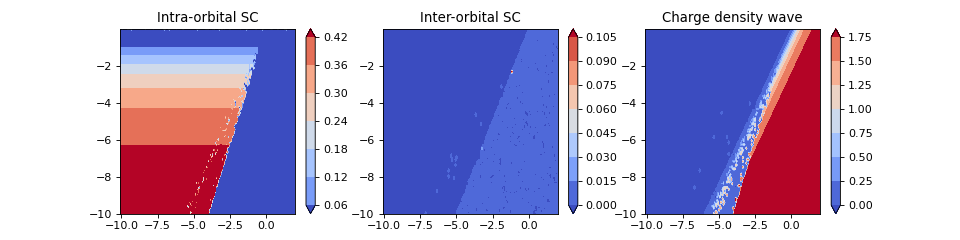

In [35]:
cmaps = ['viridis', 'coolwarm']
fig, axs = plt.subplots(1,3, figsize=(12,3))

ax = axs[0]
vmin_Del, vmax_Del = np.min(Del_intra_array), np.max(Del_intra_array)
pcm = ax.contourf(J_array, U_array, Del_intra_array, cmap=cmaps[1], vmin=vmin_Del, vmax=vmax_Del, extend="both")
fig.colorbar(pcm, ax=ax)
ax.title.set_text(r'Intra-orbital SC')

ax = axs[1]
vmin_Del, vmax_Del = np.min(Del_inter_array), np.max(Del_inter_array)
pcm = ax.contourf(J_array, U_array, Del_inter_array, cmap=cmaps[1], vmin=vmin_Del, vmax=vmax_Del, extend="both")
fig.colorbar(pcm, ax=ax)
ax.title.set_text(r'Inter-orbital SC')

ax = axs[2]
vmin_Del, vmax_Del = np.min(Del_CDW_array), np.max(Del_CDW_array)
pcm = ax.contourf(J_array, U_array, Del_CDW_array, cmap=cmaps[1], vmin=vmin_Del, vmax=vmax_Del, extend="both")
fig.colorbar(pcm, ax=ax)
ax.title.set_text(r'Charge density wave')

# Away from half-filling (not ready yet)

In [46]:
""" How many k points in the BZ """

grid_kx = np.linspace(-np.pi, np.pi, 100, endpoint = False)
grid_ky = np.linspace(-np.pi, np.pi, 100, endpoint = False)
grid_Ek = np.zeros((len(grid_kx), len(grid_ky)))

for (i, kx) in enumerate(grid_kx): 
    for (j, ky) in enumerate(grid_ky):
        k = np.array([kx, ky])
        grid_Ek[i][j] = Ek(t1, k)
    
grid_Ek2 = np.sort( abs(grid_Ek.flatten()) )[int(len(grid_Ek.flatten())/2):]
#grid_Ek2

In [17]:
""" Relate chemical potential to the number of particles per site """
mu_array = np.r_[-7 : 7 : 50j]
n = np.zeros(len(mu_array))

for (m, mu) in enumerate(mu_array):
    for (i, kx) in enumerate(grid_kx): 
        for (j, ky) in enumerate(grid_ky):
            if (grid_Ek[i][j] - mu < 0):
                n[m] += 1
            
n = n/np.square(len(grid_kx))*4

<IPython.core.display.Javascript object>


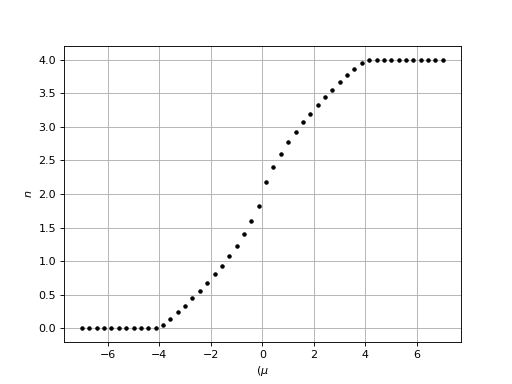

In [18]:
"""Plot of the chemical potential versus the number of particles per site"""
plt.figure()

plt.title(r'')
plt.grid()

plt.xlabel(r'$(\mu$')
plt.ylabel(r'$n$')
plt.plot(mu_array, n, '.', color = 'black')
plt.show()

In [49]:
""" Optimization with the minimization of the energy """

U_array = np.r_[ -10 : -0.001 : 20j ]
J_array = np.r_[ -10.1 : 10 : 40j ]

Del_intra_array = np.zeros((len(U_array),len(J_array)))
Del_inter_array = np.zeros((len(U_array),len(J_array)))
Del_CDW_array = np.zeros((len(U_array),len(J_array)))

""" Constraints """
cons1=({'type': 'eq', 'fun': lambda Del: Del[0]}, {'type': 'eq', 'fun': lambda Del: Del[1]}, {'type': 'eq', 'fun': lambda Del: Del[2]})
cons2=({'type': 'eq', 'fun': lambda Del: Del[0]}, {'type': 'eq', 'fun': lambda Del: Del[1]},{'type': 'ineq', 'fun': lambda Del: Del[2]})
cons3=({'type': 'eq', 'fun': lambda Del: Del[0]}, {'type': 'eq', 'fun': lambda Del: Del[2]},{'type': 'ineq', 'fun': lambda Del: Del[1]})
cons4=({'type': 'eq', 'fun': lambda Del: Del[0]},{'type': 'ineq', 'fun': lambda Del: Del[1]},{'type': 'ineq', 'fun': lambda Del: Del[2]})
cons5=({'type': 'eq', 'fun': lambda Del: Del[1]}, {'type': 'eq', 'fun': lambda Del: Del[2]},{'type': 'ineq', 'fun': lambda Del: Del[0]})
cons6=({'type': 'eq', 'fun': lambda Del: Del[1]},{'type': 'ineq', 'fun': lambda Del: Del[0]},{'type': 'ineq', 'fun': lambda Del: Del[2]})
cons7=({'type': 'eq', 'fun': lambda Del: Del[2]},{'type': 'ineq', 'fun': lambda Del: Del[0]},{'type': 'ineq', 'fun': lambda Del: Del[1]})
cons8=({'type': 'ineq', 'fun': lambda Del: Del[0]}, {'type': 'ineq', 'fun': lambda Del: Del[1]}, {'type': 'ineq', 'fun': lambda Del: Del[2]})
for l in tqdm(range(len(U_array))):
    U = U_array[l]
    for s in range(len(J_array)):
        J = J_array[s]
        x = U
        y = U - 2*J
        z = (3*U-5*J)/2
        energy = lambda Del : -2.0*np.sum( lamb_tot(grid_Ek2, x, y, z, Del[0], Del[1], Del[2]))/np.square(len(grid_kx)) -2*x*Del[0]**2.0 - 2*y*Del[1]**2.0 -z*(Del[2]/2)**2.0 
        
        if( x > 0):
            if ( y > 0):
                if ( z > 0 ):
                    a = scipy.optimize.minimize( energy , np.random.random(3), method = 'SLSQP', constraints= cons1 )
                else:
                    a = scipy.optimize.minimize( energy , np.random.random(3), method = 'SLSQP', constraints= cons2 )
                    
            else:
                
                if ( z > 0 ):
                    a = scipy.optimize.minimize( energy , np.random.random(3), method = 'SLSQP', constraints= cons3 )
                else:
                    a = scipy.optimize.minimize( energy , np.random.random(3), method = 'SLSQP', constraints= cons4 )
        
        else:
            if ( y > 0):
                if ( z > 0 ):
                    a  = scipy.optimize.minimize( energy , np.random.random(3), method = 'SLSQP', constraints= cons5 )
                else:
                    a = scipy.optimize.minimize( energy , np.random.random(3), method = 'SLSQP', constraints= cons6 )
            else:
                if ( z > 0 ):
                    a = scipy.optimize.minimize( energy , np.random.random(3), method = 'SLSQP', constraints= cons7 )
                else:   
                    a = scipy.optimize.minimize( energy , np.random.random(3), method = 'SLSQP',constraints= cons8)
                    
        Del_intra_array[l][s] = a.x[0]
        Del_inter_array[l][s] = a.x[1]
        Del_CDW_array[l][s] = a.x[2]

100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  5.28it/s]


<IPython.core.display.Javascript object>


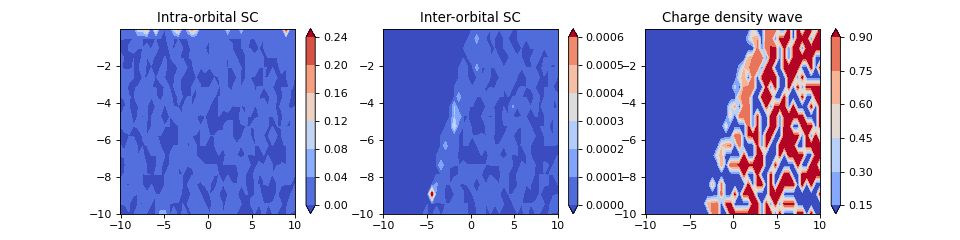

In [50]:
cmaps = ['viridis', 'coolwarm']
fig, axs = plt.subplots(1,3, figsize=(12,3))

ax = axs[0]
vmin_Del, vmax_Del = np.min(Del_intra_array), np.max(Del_intra_array)
pcm = ax.contourf(J_array, U_array, Del_intra_array, cmap=cmaps[1], vmin=vmin_Del, vmax=vmax_Del, extend="both")
fig.colorbar(pcm, ax=ax)
ax.title.set_text(r'Intra-orbital SC')

ax = axs[1]
vmin_Del, vmax_Del = np.min(Del_inter_array), np.max(Del_inter_array)
pcm = ax.contourf(J_array, U_array, Del_inter_array, cmap=cmaps[1], vmin=vmin_Del, vmax=vmax_Del, extend="both")
fig.colorbar(pcm, ax=ax)
ax.title.set_text(r'Inter-orbital SC')

ax = axs[2]
vmin_Del, vmax_Del = np.min(Del_CDW_array), np.max(Del_CDW_array)
pcm = ax.contourf(J_array, U_array, Del_CDW_array, cmap=cmaps[1], vmin=vmin_Del, vmax=vmax_Del, extend="both")
fig.colorbar(pcm, ax=ax)
ax.title.set_text(r'Charge density wave')